# ¿Cuál es la mejor tarifa?

Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de las tarifas genera más ingresos para poder ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

Verifiquemos entonces los hábitos de los usuarios de la empresa para poder encontrar formas de maximizar los beneficios.

## Inicialización

In [56]:
# Cargar todas las librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [57]:
#Definimos una función de apoyo para poder explorar rápidamente los datos en cada DF

def verificar(df):
    """Función para verificar errores comunes Data frames"""
    print("=== VERIFICACIÓN ===")

    # 1. Información básica
    print(f"Forma: {df.shape}")
    print(f"Columnas: {list(df.columns)}")

    # 2. Valores nulos
    print(f"\nValores nulos:\n{df.isnull().sum()}")

    # 3. Tipos de datos
    print(f"\nTipos de datos:\n{df.dtypes}")
    
    # 4. Duplicados
    print(f"\nFilas duplicadas: {df.duplicated().sum()}")
    
    # 5. Estadísticas básicas
    print(f"\nEstadísticas descriptivas:")
    print(df.describe())
    

## Cargar datos

In [58]:
# Carga los archivos de datos en diferentes DataFrames
df_calls = pd.read_csv('datasets/megaline_calls.csv')
df_internet = pd.read_csv('datasets/megaline_internet.csv')
df_messages = pd.read_csv('datasets/megaline_messages.csv')
df_plans = pd.read_csv('datasets/megaline_plans.csv')
df_users = pd.read_csv('datasets/megaline_users.csv')

## Preparar los datos

Cada una de las tablas es complemento para comprender la informacion de manera completa así que es necesario comprender los vínculos para poder hacer un análisis completo.

## Tarifas

In [59]:
# Imprime la información general/resumida sobre el DataFrame de las tarifas
df_plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 260.0+ bytes


In [60]:
# Imprime una muestra de los datos para las tarifas
display(df_plans.head())

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


La tabla contiene los tipos de datos correctos, no hay valores faltantes o incorrectos, la tabla es muy pequeña en datos.

## Corregir datos

Esta tabla está completa. Tiene solamente datos relevantes.

## Enriquecer los datos

Es una tabla muy intuitiva y con datos suficientes.

## Usuarios/as

In [61]:
# Imprime la información general/resumida sobre el DataFrame de usuarios
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [62]:
# Imprime una muestra de datos para usuarios
display(df_users.head())

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


El uso de mayúsculas puede causar errores o que se nos escape en alguna estadística un dato valioso, considero necesario cambiar los datos a minúsculas. 

Las fechas tienen tipo de datos incorrecto, deben ser del tipo datetime64 y no object.

La columna ciudad puede categorizarse por estado también.

### Corregir los datos

Pondermos la columna de los nombres y la ciudad en minuscula

Adicional cambiaremos el tipo de datos de las columnas 'reg_time' y 'churn_date'

In [63]:
df_users['first_name'] = df_users['first_name'].str.lower()
df_users['last_name'] = df_users['last_name'].str.lower()
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'])
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'])
df_users.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


### Enriquecer los datos

Para conocer el promedio de duracion de los contratos, es de utilidad hacer la diferencia entre churn_dat y reg_date

In [64]:
df_users[['city_name', 'state_info']] = df_users['city'].str.split(',', expand=True)
grupo_ciudad = df_users.groupby(by = 'city_name')['user_id'].count()
df_users['tiempo_contratado'] = df_users['churn_date'] - df_users['reg_date']



## Llamadas

In [65]:
# Imprime la información general/resumida sobre el DataFrame de las llamadas
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [66]:
# Imprime una muestra de datos para las llamadas
display(df_calls.head())



,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


Esta tabla registra las llamadas hechas por los usuarios y la duracion de las mismas, en el identificador de las llamadas se usa el user id y un id para la llamada.

### Corregir los datos

Debemos corregir el tipo de datos para call_date


In [67]:
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'])
display(df_calls.head())

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


### Enriquecer los datos

Separemos el identificador de cada llamada para trabajar por separado cada id de llamada, adicional considero necesario hacer una columna para el mes de registro.

In [68]:
df_calls['id_sin_user'] = df_calls['id'].str.split('_').str[1].str.strip()
#extraemos mes y año.
df_calls['mes_llamada'] = df_calls['call_date'].dt.month
df_calls['año_llamada'] = df_calls['call_date'].dt.year

# Crear una columna combinada año-mes
df_calls['año_mes'] = df_calls['call_date'].dt.to_period('M')
df_calls.head()

,id,user_id,call_date,duration,id_sin_user,mes_llamada,año_llamada,año_mes
0,1000_93,1000,2018-12-27,8.52,93,12,2018,2018-12
1,1000_145,1000,2018-12-27,13.66,145,12,2018,2018-12
2,1000_247,1000,2018-12-27,14.48,247,12,2018,2018-12
3,1000_309,1000,2018-12-28,5.76,309,12,2018,2018-12
4,1000_380,1000,2018-12-30,4.22,380,12,2018,2018-12


## Mensajes

In [69]:
# Imprime la información general/resumida sobre el DataFrame de los mensajes
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [70]:
# Imprime una muestra de datos para los mensajes
display(df_messages.head())


,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


He observado que hay un tipo de datos incorrecto en message_date

### Corregir los datos

Cambiamos el tipo de datos a fecha, de message_date.

In [71]:
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'])

### Enriquecer los datos

Puede llegar a ser util el identificador de los mensajes, así como trabajar con el mes y año por separado.

In [72]:
df_messages['id_no_user'] = df_messages['id'].str.split('_').str[1].str.strip() 
#extraemos mes y año.
df_messages['mes'] = df_messages['message_date'].dt.month
df_messages['año'] = df_messages['message_date'].dt.year

# Crear una columna combinada año-mes
df_messages['año_mes'] = df_messages['message_date'].dt.to_period('M')

display(df_messages)

,id,user_id,message_date,id_no_user,mes,año,año_mes
0,1000_125,1000,2018-12-27,125,12,2018,2018-12
1,1000_160,1000,2018-12-31,160,12,2018,2018-12
2,1000_223,1000,2018-12-31,223,12,2018,2018-12
3,1000_251,1000,2018-12-27,251,12,2018,2018-12
4,1000_255,1000,2018-12-26,255,12,2018,2018-12
...,...,...,...,...,...,...,...
76046,1497_526,1497,2018-12-24,526,12,2018,2018-12
76047,1497_536,1497,2018-12-24,536,12,2018,2018-12
76048,1497_547,1497,2018-12-31,547,12,2018,2018-12
76049,1497_558,1497,2018-12-24,558,12,2018,2018-12


## Internet

In [73]:
# Imprime la información general/resumida sobre el DataFrame de internet
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [74]:
# Imprime una muestra de datos para el tráfico de internet

display(df_internet.head())

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


Hay que corregir el tipo de dato de session_date a fecha

### Corregir los datos

In [75]:
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'])

### Enriquecer los datos

In [76]:
df_internet['id_no_user'] = df_internet['id'].str.split('_').str[1].str.strip()
#extraemos mes y año.
df_internet['mes'] = df_internet['session_date'].dt.month
df_internet['año'] = df_internet['session_date'].dt.year

# Crear una columna combinada año-mes
df_internet['año_mes'] = df_internet['session_date'].dt.to_period('M')

display(df_internet)

,id,user_id,session_date,mb_used,id_no_user,mes,año,año_mes
0,1000_13,1000,2018-12-29,89.86,13,12,2018,2018-12
1,1000_204,1000,2018-12-31,0.00,204,12,2018,2018-12
2,1000_379,1000,2018-12-28,660.40,379,12,2018,2018-12
3,1000_413,1000,2018-12-26,270.99,413,12,2018,2018-12
4,1000_442,1000,2018-12-27,880.22,442,12,2018,2018-12
...,...,...,...,...,...,...,...,...
104820,1499_215,1499,2018-10-20,218.06,215,10,2018,2018-10
104821,1499_216,1499,2018-12-30,304.72,216,12,2018,2018-12
104822,1499_217,1499,2018-09-22,292.75,217,9,2018,2018-09
104823,1499_218,1499,2018-12-07,0.00,218,12,2018,2018-12


## Estudiar las condiciones de las tarifas

El plan surf incluye 50 mensajes, 15360 mb para navegar y 500 minutos de llamada por un total de 20 USD al mes, por mensaje y minuto adicional se cobra 0.03 USD cada uno, por GB adicional se cobra 10 USD es decir que por mb adicional se cobra 0.01 USD 
El plan ultimate incluye 1000 mensajes, 30720 mb para navegar y 3000 minutos de llamada por un total de 70 USD al mes, por mensaje y minuto adicional se cobra 0.01 USD cada uno, por GB adicional se cobra 7 USD es decir que por mb adicional se cobra 0.007 USD 

In [77]:
# Imprime las condiciones de la tarifa y asegúrate de que te quedan claras0
display(df_plans.head())
display(df_calls.head(30))

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


,id,user_id,call_date,duration,id_sin_user,mes_llamada,año_llamada,año_mes
0,1000_93,1000,2018-12-27,8.52,93,12,2018,2018-12
1,1000_145,1000,2018-12-27,13.66,145,12,2018,2018-12
2,1000_247,1000,2018-12-27,14.48,247,12,2018,2018-12
3,1000_309,1000,2018-12-28,5.76,309,12,2018,2018-12
4,1000_380,1000,2018-12-30,4.22,380,12,2018,2018-12
5,1000_388,1000,2018-12-31,2.20,388,12,2018,2018-12
6,1000_510,1000,2018-12-27,5.75,510,12,2018,2018-12
7,1000_521,1000,2018-12-28,14.18,521,12,2018,2018-12
8,1000_530,1000,2018-12-28,5.77,530,12,2018,2018-12
9,1000_544,1000,2018-12-26,4.40,544,12,2018,2018-12


## Agregar datos por usuario

[Ahora que los datos están limpios, agrega los datos por usuario y por periodo para que solo haya un registro por usuario y por periodo. Esto facilitará mucho el análisis posterior.]

In [78]:
# Calcula el número de llamadas hechas por cada usuario al mes. Guarda el resultado.
llamadas_mes = df_calls.groupby(['user_id', 'año_mes'])['duration'].count().reset_index(name='llamadas_totales')
display(llamadas_mes)

,user_id,año_mes,llamadas_totales
0,1000,2018-12,16
1,1001,2018-08,27
2,1001,2018-09,49
3,1001,2018-10,65
4,1001,2018-11,64
...,...,...,...
2253,1498,2018-12,39
2254,1499,2018-09,41
2255,1499,2018-10,53
2256,1499,2018-11,45


In [79]:
# Calcula la cantidad de minutos usados por cada usuario al mes. Guarda el resultado.

minutos_mes = df_calls.groupby(['user_id', 'año_mes'])['duration'].sum().reset_index(name='minutos_totales')
display(minutos_mes)

,user_id,año_mes,minutos_totales
0,1000,2018-12,116.83
1,1001,2018-08,171.14
2,1001,2018-09,297.69
3,1001,2018-10,374.11
4,1001,2018-11,404.59
...,...,...,...
2253,1498,2018-12,324.77
2254,1499,2018-09,330.37
2255,1499,2018-10,363.28
2256,1499,2018-11,288.56


In [80]:
# Calcula el número de mensajes enviados por cada usuario al mes. Guarda el resultado.

mensajes_mes = df_messages.groupby(['user_id', 'año_mes'])['id_no_user'].count().reset_index(name='mensajes_totales')
display(mensajes_mes)

,user_id,año_mes,mensajes_totales
0,1000,2018-12,11
1,1001,2018-08,30
2,1001,2018-09,44
3,1001,2018-10,53
4,1001,2018-11,36
...,...,...,...
1801,1496,2018-09,21
1802,1496,2018-10,18
1803,1496,2018-11,13
1804,1496,2018-12,11


In [81]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
 4   id_no_user    104825 non-null  object        
 5   mes           104825 non-null  int32         
 6   año           104825 non-null  int32         
 7   año_mes       104825 non-null  period[M]     
dtypes: datetime64[ns](1), float64(1), int32(2), int64(1), object(2), period[M](1)
memory usage: 5.6+ MB


In [82]:
# Calcula el volumen del tráfico de Internet usado por cada usuario al mes. Guarda el resultado.

internet_mes = df_internet.groupby(['user_id', 'año_mes'])['mb_used'].sum().reset_index(name='mb_totales')
display(internet_mes)

,user_id,año_mes,mb_totales
0,1000,2018-12,1901.47
1,1001,2018-08,6919.15
2,1001,2018-09,13314.82
3,1001,2018-10,22330.49
4,1001,2018-11,18504.30
...,...,...,...
2272,1498,2018-12,23137.69
2273,1499,2018-09,12984.76
2274,1499,2018-10,19492.43
2275,1499,2018-11,16813.83


Información de consumo de cada usuario

In [83]:
# Fusiona los datos de llamadas, minutos, mensajes e Internet con base en user_id y month

fusion = pd.merge(llamadas_mes, minutos_mes, how= 'left', on = ['user_id', 'año_mes'])
fusion = pd.merge(fusion, mensajes_mes, how= 'left', on = ['user_id', 'año_mes'])
fusion = pd.merge(fusion, internet_mes, how= 'left', on = ['user_id', 'año_mes'])
display(fusion)

,user_id,año_mes,llamadas_totales,minutos_totales,mensajes_totales,mb_totales
0,1000,2018-12,16,116.83,11.0,1901.47
1,1001,2018-08,27,171.14,30.0,6919.15
2,1001,2018-09,49,297.69,44.0,13314.82
3,1001,2018-10,65,374.11,53.0,22330.49
4,1001,2018-11,64,404.59,36.0,18504.30
...,...,...,...,...,...,...
2253,1498,2018-12,39,324.77,NaN,23137.69
2254,1499,2018-09,41,330.37,NaN,12984.76
2255,1499,2018-10,53,363.28,NaN,19492.43
2256,1499,2018-11,45,288.56,NaN,16813.83


In [84]:
# Añade la información de la tarifa
fusion = pd.merge(fusion, df_users, how= 'left', on = ['user_id'])
fusion = pd.merge(fusion, df_plans, how= 'left', left_on = 'plan', right_on = 'plan_name')
display(fusion.head())

,user_id,año_mes,llamadas_totales,minutos_totales,mensajes_totales,mb_totales,first_name,last_name,age,city,...,state_info,tiempo_contratado,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,1000,2018-12,16,116.83,11.0,1901.47,anamaria,bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",...,GA MSA,NaT,1000,30720,3000,70,7,0.01,0.01,ultimate
1,1001,2018-08,27,171.14,30.0,6919.15,mickey,wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",...,WA MSA,NaT,50,15360,500,20,10,0.03,0.03,surf
2,1001,2018-09,49,297.69,44.0,13314.82,mickey,wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",...,WA MSA,NaT,50,15360,500,20,10,0.03,0.03,surf
3,1001,2018-10,65,374.11,53.0,22330.49,mickey,wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",...,WA MSA,NaT,50,15360,500,20,10,0.03,0.03,surf
4,1001,2018-11,64,404.59,36.0,18504.30,mickey,wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",...,WA MSA,NaT,50,15360,500,20,10,0.03,0.03,surf


In [85]:
# Calcula el ingreso mensual para cada usuario
# Hice una columna para cada exceso y su costo al mes, usando el maximo entre 0 y la diferencia de lo que incluye cada paquete con lo que el cliente uso.
# Al final sumamos el costo del paquete mas los costos adicionales por exceso de uso de minutos, mb y mensajes.
fusion['excedente_mensajes'] = np.maximum(0,fusion['messages_included'] - fusion['mensajes_totales'])
fusion['costo_excedente_mensajes'] = fusion['excedente_mensajes'] * fusion['usd_per_message']
fusion['excedente_mb'] = np.maximum(0, fusion['mb_per_month_included'] - fusion['mb_totales'])
fusion['costo_excente_mb'] = fusion['excedente_mb'] * fusion['usd_per_gb'] / 1024
fusion['excedente_minutos'] = np.maximum(0, fusion['minutes_included'] - fusion['minutos_totales'])
fusion['costo_excedente_minutos'] = fusion['excedente_minutos'] * fusion['usd_per_minute']
fusion['gasto_usuario_mes'] = fusion['usd_monthly_pay'] + fusion['costo_excedente_minutos'] + fusion['costo_excente_mb'] + fusion['costo_excedente_mensajes']
display(fusion.head())

,user_id,año_mes,llamadas_totales,minutos_totales,mensajes_totales,mb_totales,first_name,last_name,age,city,...,usd_per_message,usd_per_minute,plan_name,excedente_mensajes,costo_excedente_mensajes,excedente_mb,costo_excente_mb,excedente_minutos,costo_excedente_minutos,gasto_usuario_mes
0,1000,2018-12,16,116.83,11.0,1901.47,anamaria,bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",...,0.01,0.01,ultimate,989.0,9.89,28818.53,197.001670,2883.17,28.8317,305.723370
1,1001,2018-08,27,171.14,30.0,6919.15,mickey,wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",...,0.03,0.03,surf,20.0,0.60,8440.85,82.430176,328.86,9.8658,112.895976
2,1001,2018-09,49,297.69,44.0,13314.82,mickey,wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",...,0.03,0.03,surf,6.0,0.18,2045.18,19.972461,202.31,6.0693,46.221761
3,1001,2018-10,65,374.11,53.0,22330.49,mickey,wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",...,0.03,0.03,surf,0.0,0.00,0.00,0.000000,125.89,3.7767,23.776700
4,1001,2018-11,64,404.59,36.0,18504.30,mickey,wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",...,0.03,0.03,surf,14.0,0.42,0.00,0.000000,95.41,2.8623,23.282300


## Estudia el comportamiento de usuario

Hagamos un análisis grafico de cual tarifa es la mejor según las estadísticas de consumo. Mostremos el panorama generral y hagamos un recap de los datos comparandolos con la información mas relevante.

### Llamadas

In [86]:
# Compara la duración promedio de llamadas por cada plan y por cada mes. Traza un gráfico de barras para visualizarla.
llamadas_plan = fusion.groupby(['plan', 'año_mes'])['minutos_totales'].mean().reset_index(name='promedio')
display(llamadas_plan)

,plan,año_mes,promedio
0,surf,2018-01,192.840000
1,surf,2018-02,280.851111
2,surf,2018-03,310.970000
3,surf,2018-04,332.380000
4,surf,2018-05,387.108000
5,surf,2018-06,411.450625
6,surf,2018-07,428.060917
7,surf,2018-08,394.474717
8,surf,2018-09,397.133298
9,surf,2018-10,414.435733


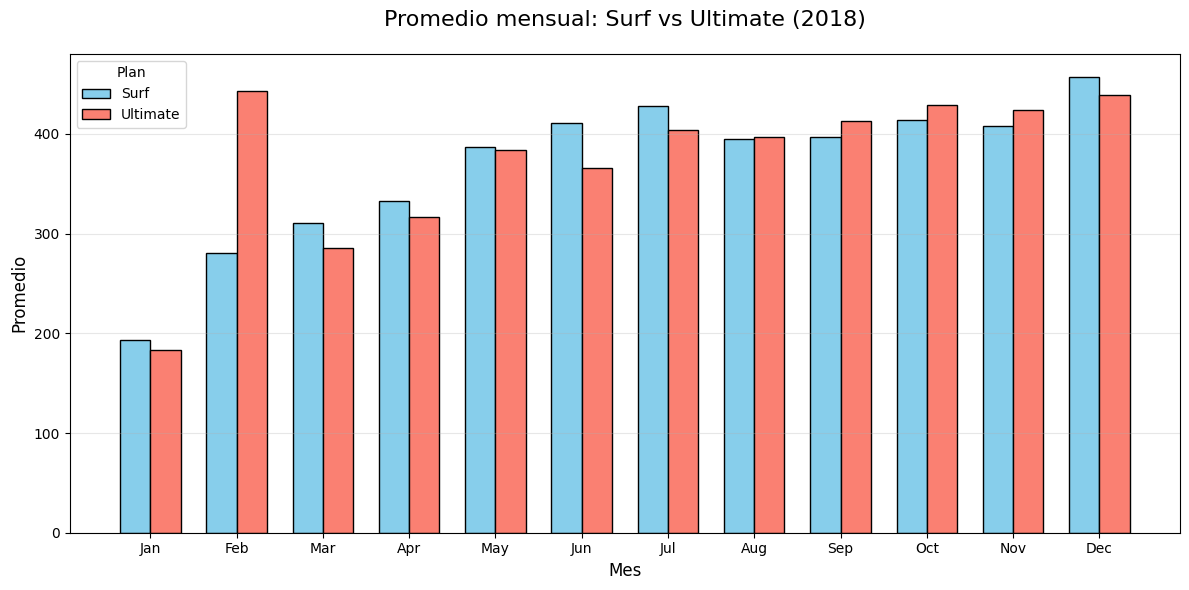

In [87]:
# Compara el número de minutos mensuales que necesitan los usuarios de cada plan. Traza un histograma.

# Pivotear para tener meses en X y planes en columnas
df_pivot = llamadas_plan.pivot(index='año_mes', columns='plan', values='promedio')

# --- GRÁFICA DE BARRAS AGRUPADAS ---
plt.figure(figsize=(12, 6))

# Ancho de barras
bar_width = 0.35
index = range(len(df_pivot))

# Barras para 'surf'
plt.bar([i - bar_width/2 for i in index], df_pivot['surf'],
        width=bar_width, label='Surf', color='skyblue', edgecolor='black')

# Barras para 'ultimate'
plt.bar([i + bar_width/2 for i in index], df_pivot['ultimate'],
        width=bar_width, label='Ultimate', color='salmon', edgecolor='black')

# Personalización
plt.title('Promedio mensual: Surf vs Ultimate (2018)', fontsize=16, pad=20)
plt.xlabel('Mes', fontsize=12)
plt.ylabel('Promedio', fontsize=12)
plt.legend(title='Plan')
plt.grid(True, axis='y', alpha=0.3)

# Etiquetas en X: formato "Ene", "Feb", etc.
meses = df_pivot.index.strftime('%b')
plt.xticks(index, meses)

# Ajustar diseño
plt.tight_layout()
plt.show()

Hagamos el cálculo estadístico para ver mas detalles sobre las llamadas.

In [93]:
# Calcula la media y la varianza de la duración mensual de llamadas.
estadisticas_llamadas = llamadas_plan.groupby('plan')['promedio'].agg(media = 'mean', varianza = 'var').round(2)
print(estadisticas_llamadas)

           media  varianza
plan                      
surf      367.96   5636.60
ultimate  373.65   5925.11


El promedio mensual del plan "ultimate" es un poco mas elevado que el plan "surf" al igual que su varianza.

<Figure size 800x600 with 0 Axes>

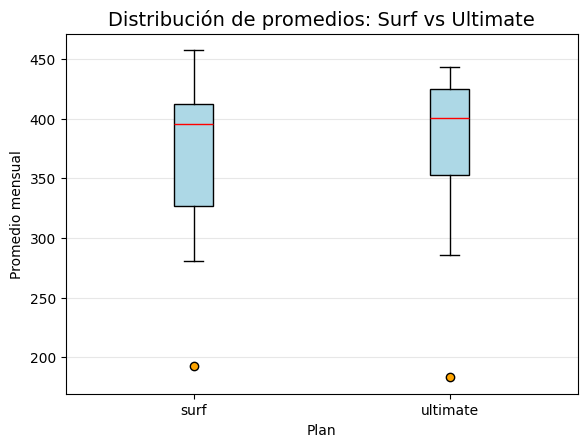

In [94]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas

plt.figure(figsize=(8, 6))
llamadas_plan.boxplot(column='promedio', by='plan', grid=False, patch_artist=True,
           boxprops=dict(facecolor='lightblue', color='black'),
           medianprops=dict(color='red'),
           whiskerprops=dict(color='black'),
           capprops=dict(color='black'),
           flierprops=dict(marker='o', markerfacecolor='orange', markersize=6))

plt.title('Distribución de promedios: Surf vs Ultimate', fontsize=14)
plt.suptitle('')  # Quita el subtítulo automático
plt.xlabel('Plan')
plt.ylabel('Promedio mensual')
plt.grid(True, axis='y', alpha=0.3)
plt.show()

Podemos notar que los usuarios del plan surf tienden a gastar en un rango más amplio, pero la mayoria de ellos gasta entre 325 USD y 410 USD mientras que los usuarios del plan ultimate en su mayoria gastan entre 350 y 425 USD

### Mensajes

In [101]:
# Comprara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan

mensajes_plan = fusion.groupby(['plan', 'año_mes'])['mensajes_totales'].mean().reset_index(name='promedio')
pivot_mensajes = mensajes_plan.pivot(index = 'año_mes', columns = 'plan', values = 'promedio')
display(pivot_mensajes)

plan,surf,ultimate
año_mes,,
2018-01,21.000000,20.666667
2018-02,21.600000,27.800000
2018-03,21.937500,34.714286
2018-04,24.166667,28.937500
2018-05,33.870370,44.333333
2018-06,33.708333,37.135135
2018-07,36.033333,41.212766
2018-08,37.917355,47.929825
2018-09,39.202703,45.901408


In [ ]:
# Compara la cantidad de tráfico de Internet consumido por usuarios por plan



[Elabora las conclusiones sobre el comportamiento de los usuarios con respecto a los mensajes. ¿Su comportamiento varía en función del plan?]

### Internet

[Elabora las conclusiones sobre cómo los usuarios tienden a consumir el tráfico de Internet. ¿Su comportamiento varía en función del plan?]

## Ingreso

[Del mismo modo que has estudiado el comportamiento de los usuarios, describe estadísticamente los ingresos de los planes.]

[Elabora las conclusiones sobre cómo difiere el ingreso entre los planes.]

## Prueba las hipótesis estadísticas

[Prueba la hipótesis de que son diferentes los ingresos promedio procedentes de los usuarios de los planes de llamada Ultimate y Surf.]

[Elabora las hipótesis nula y alternativa, escoge la prueba estadística, determina el valor alfa.]

In [ ]:
# Prueba las hipótesis



[Prueba la hipótesis de que el ingreso promedio de los usuarios del área NY-NJ es diferente al de los usuarios de otras regiones.]

[Elabora las hipótesis nula y alternativa, escoge la prueba estadística, determina el valor alfa.]

In [ ]:
# Prueba las hipótesis



## Conclusión general

[En esta sección final, enumera tus conclusiones importantes. Asegúrate de que estas abarquen todas las decisiones (suposiciones) importantes que adoptaste y que determinaron la forma elegida para procesar y analizar los datos.]